4659


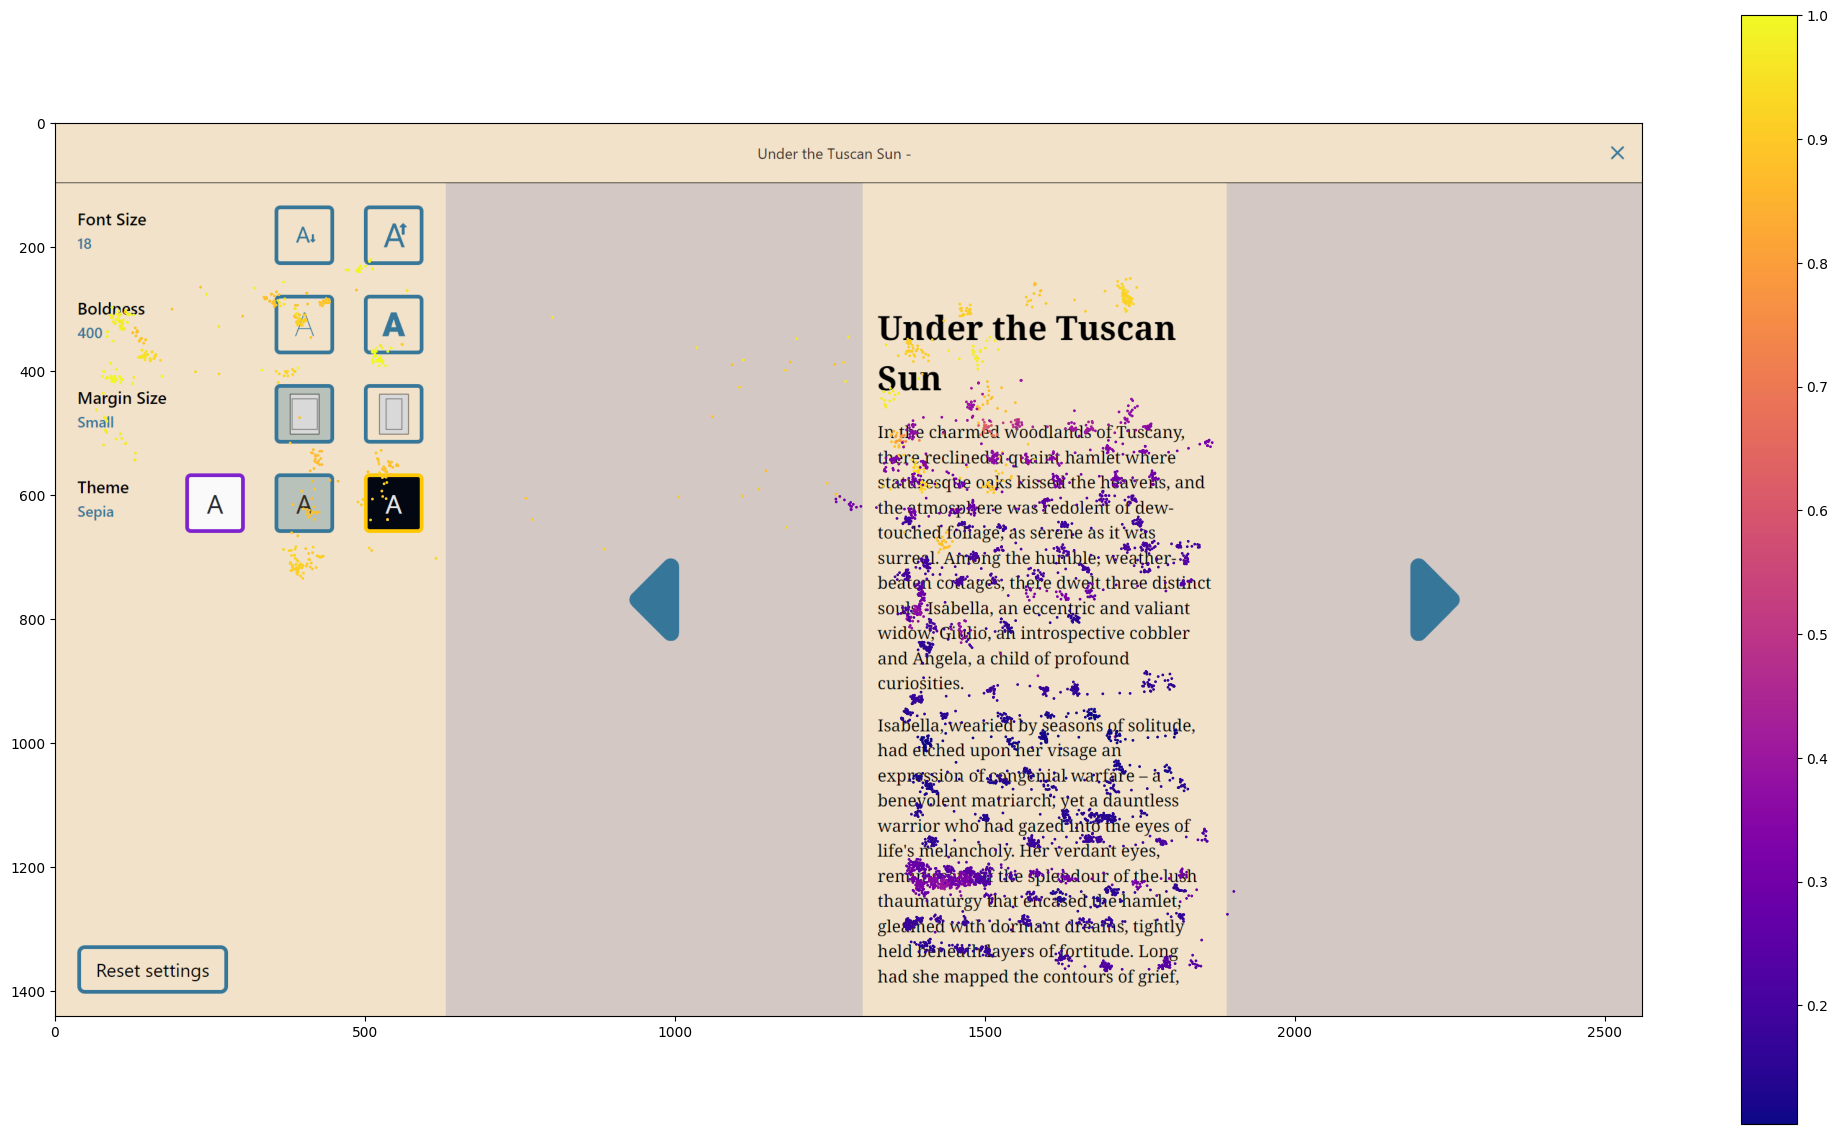

1


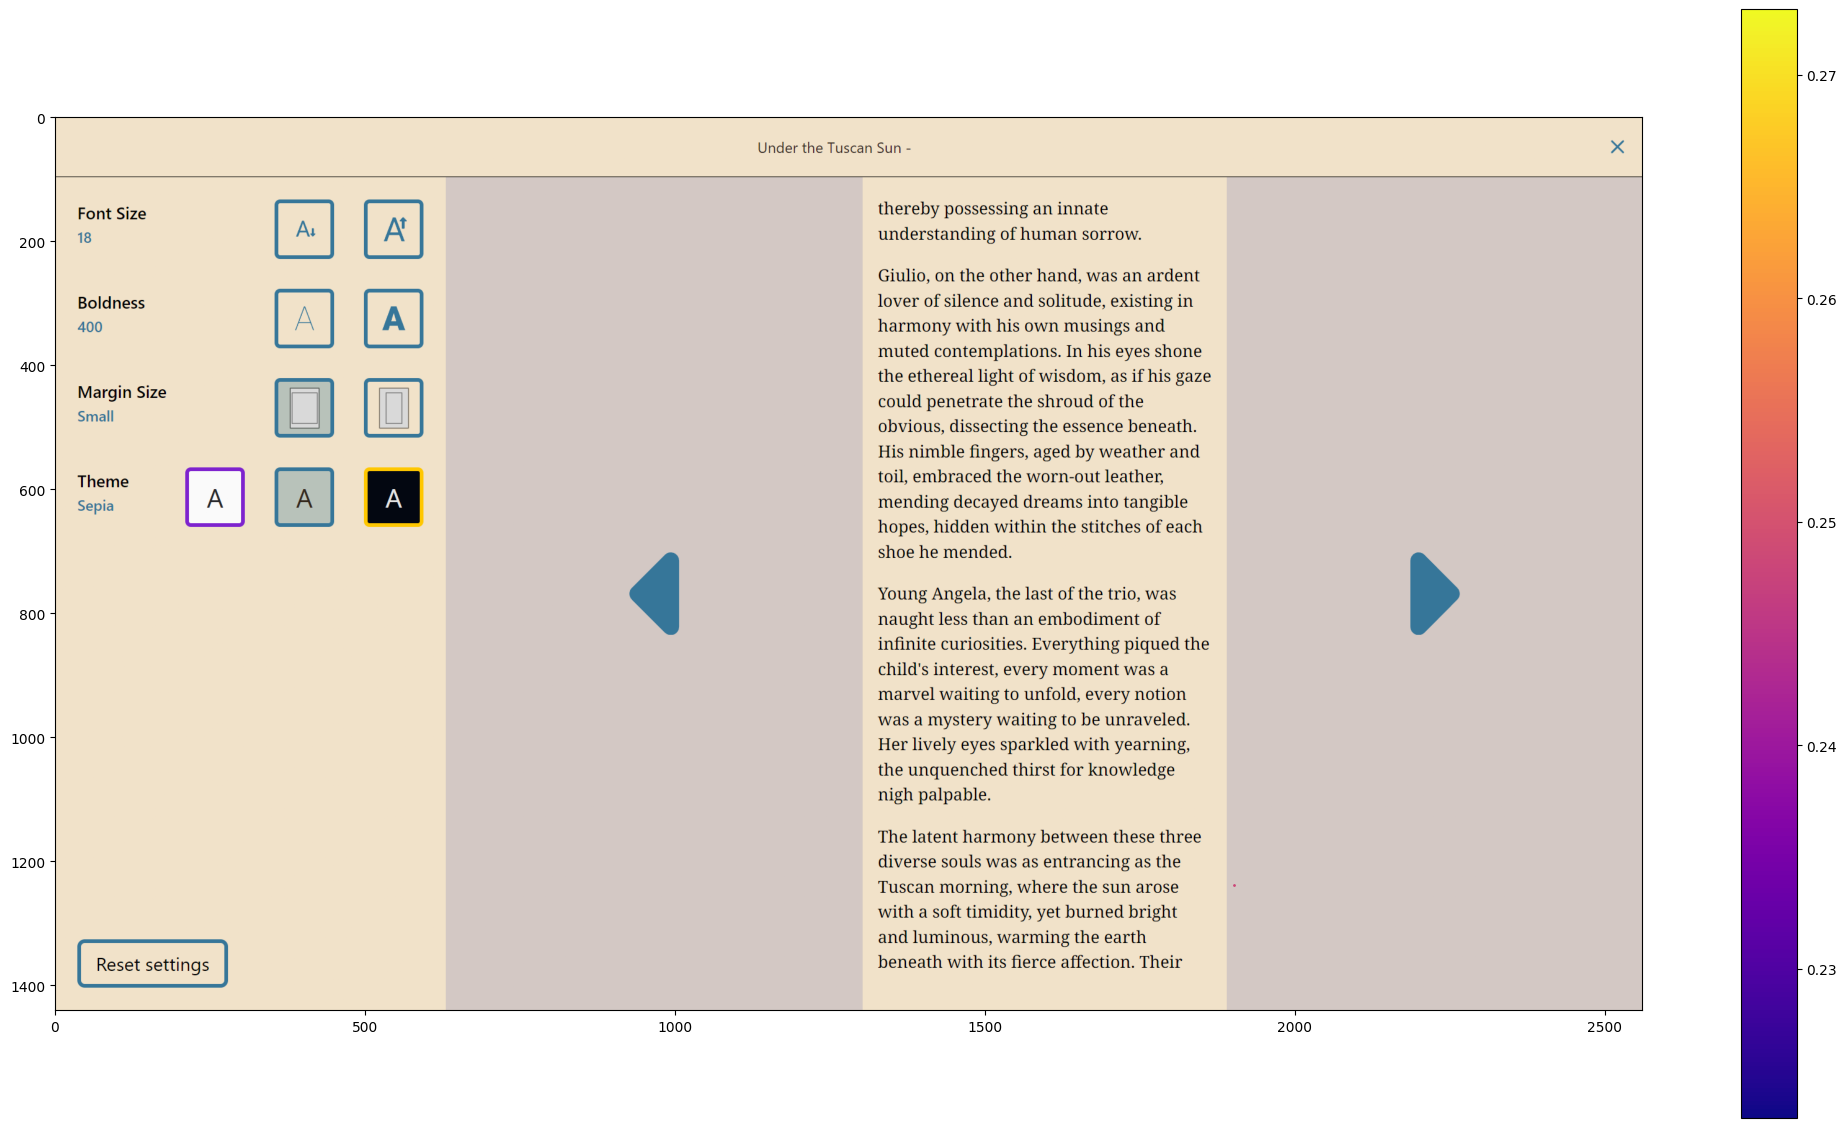

0


KeyError: 'left_gaze_point_on_display_area'

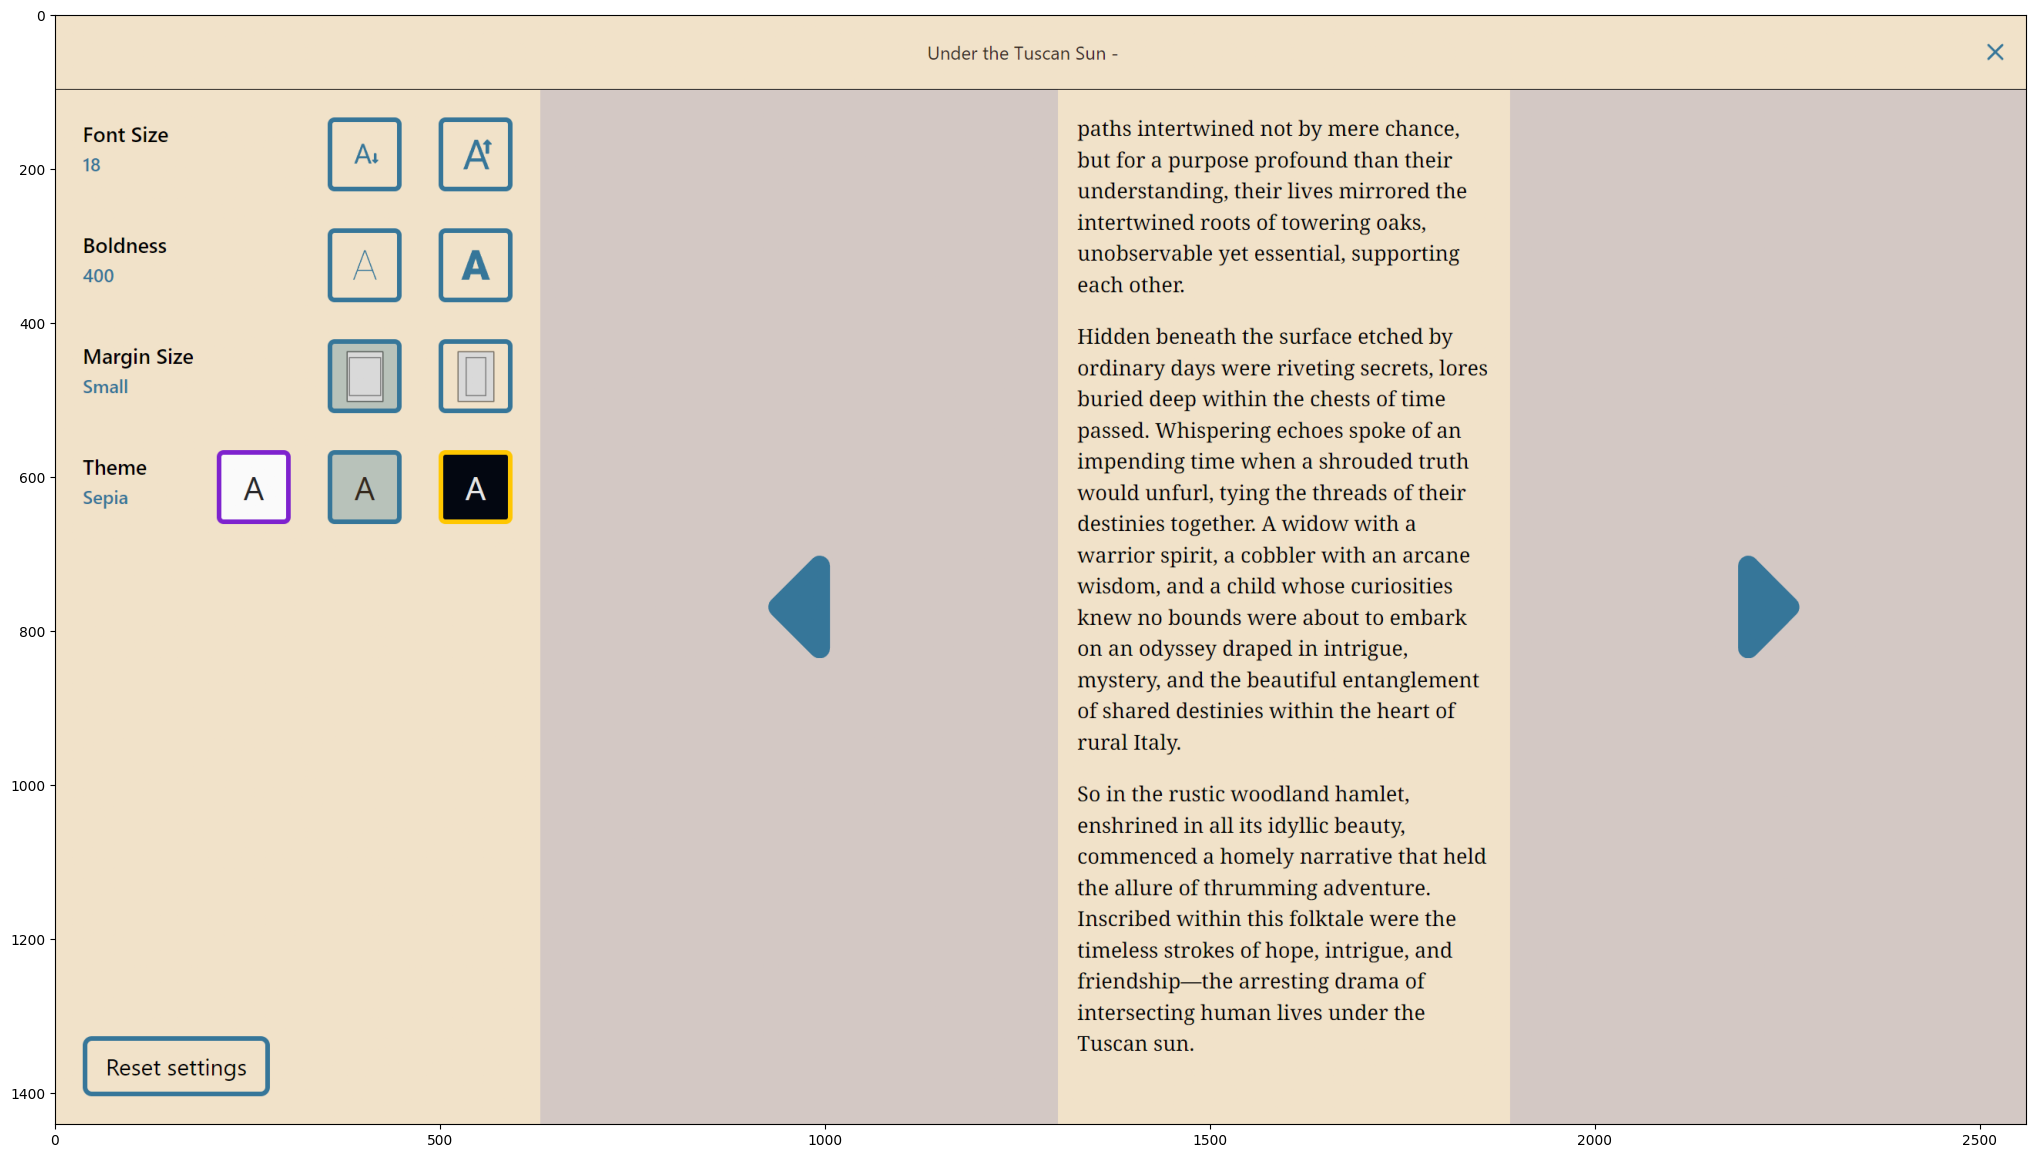

In [28]:
from datetime import datetime
import matplotlib.pyplot as plt
from utils import (
    X_PIXELS,
    Y_PIXELS,
    extract_gaze_data_between_timestamps_proper,
    Events,
)
import json
import pandas as pd

EYE_TRACKER_FOLDER = "eye_tracker_data/"
GAZE_DATA = []
GAZE_DATA_BOOK = []
GAZE_DATA_PAGE = []

# participants that were told that they can change the settings beforehand
participant_ids = [998]
subquery = Events.select().where(Events.participant_id.in_(participant_ids))

for participant in participant_ids:
    for book in subquery.where(Events.event == "OPEN_BOOK"):
        START_TIME_BOOK = book.time
        END_TIME_BOOK = (
            subquery.where(Events.event == "CLOSE_BOOK")
            .where(Events.time > START_TIME_BOOK)
            .get()
            .time
        )

        formatted_time = datetime.fromtimestamp(START_TIME_BOOK / 1000).strftime(
            "%Y-%m-%d_%H-%M-%S"
        )
        GAZE_FILE = f"{EYE_TRACKER_FOLDER}[{participant}]-{formatted_time}.json"
        f = open(GAZE_FILE, "r")
        GAZE_DATA = json.load(f)
        f.close()
        GAZE_DATA_BOOK = extract_gaze_data_between_timestamps_proper(
            GAZE_DATA, START_TIME_BOOK, END_TIME_BOOK
        )

        # Load into pandas dataframe
        df = pd.DataFrame(GAZE_DATA_BOOK["data"])

        # The average pupil diameter is calculated as the average of the left and right pupil diameter
        # There can be None values in the pupil diameter, so we drop those
        df["pupil_diameter"] = df[["left_pupil_diameter", "right_pupil_diameter"]].mean(
            axis=1
        )
        # Calculate the rolling average
        df["pupil_diameter"] = df["pupil_diameter"].rolling(50).mean()
        df = df.dropna(subset=["pupil_diameter"])

        # Normalize the pupil diameter for use in the colour of the plot
        df["normalized_pupil_diameter"] = (
            df["pupil_diameter"] - df["pupil_diameter"].min()
        ) / (df["pupil_diameter"].max() - df["pupil_diameter"].min())

        # Create a new column 'color-from-pupil-diameter' which is
        # the y value of the normalized pupil diameter from the

        # Add the df back to the GAZE_DATA_BOOK
        GAZE_DATA_BOOK["data"] = df.to_dict("records")

        # Get the events that have a timestamp less than the first CLOSE_BOOK event
        events_book = subquery.where(Events.time <= END_TIME_BOOK)

        for page in subquery.where(Events.event == "NEXT_PAGE").where(
            Events.time > START_TIME_BOOK
        ):
            START_TIME_PAGE = page.time
            end_page = (
                events_book.where(Events.event.in_(["NEXT_PAGE", "CLOSE_BOOK"]))
                .where(Events.time > START_TIME_PAGE)
                .get_or_none()
            )
            if end_page is None:
                continue
            END_TIME_PAGE = end_page.time

            # if END_TIME_PAGE - START_TIME_PAGE < 1000:
                # continue

            # Get the event one before the end page event
            screenshot_event = (
                events_book.where(Events.time < END_TIME_PAGE)
                .order_by(Events.time.desc())
                .get()
            )

            fig, ax = plt.subplots(figsize=(X_PIXELS / 100, Y_PIXELS / 100))

            ax.set_xlim(0, X_PIXELS)
            ax.set_ylim(Y_PIXELS, 0)


            # Get the image to display on the plot
            image_file = screenshot_event.screenshot_file
            ax.imshow(plt.imread(image_file), extent=[0, X_PIXELS, Y_PIXELS, 0])

            # Get the gaze data for the page
            GAZE_DATA_PAGE = extract_gaze_data_between_timestamps_proper(
                GAZE_DATA_BOOK, START_TIME_PAGE, END_TIME_PAGE
            )
            print(len(GAZE_DATA_PAGE["data"]))
            # Create empty dataframe and then insert the data
            df_page = pd.DataFrame()
            df_page = pd.DataFrame(GAZE_DATA_PAGE["data"])

            # Some of these points are [None, None], so we drop those
            df_page = df_page[
                df_page["left_gaze_point_on_display_area"].apply(
                    lambda x: x != [None, None]
                )
            ]

            # Multiply all the gaze points, which are in the format
            # [X, Y] by the in the respective pixel dimensions
            df_page["left_gaze_point_on_display_area"] = df_page[
                "left_gaze_point_on_display_area"
            ].apply(lambda x: [x[0] * X_PIXELS, x[1] * Y_PIXELS])

            p = ax.scatter(
                x=df_page["left_gaze_point_on_display_area"].apply(lambda x: x[0]),
                y=df_page["left_gaze_point_on_display_area"].apply(lambda x: x[1]),
                c=df_page["normalized_pupil_diameter"],
                cmap="plasma",
                s=1,
            )
            plt.colorbar(p)
            plt.show()